# Lab Assignment 4: Support Vector Machines

## Library installation
In this assignment we will use the `cvxopt` package, [whose documentation can be found here](https://cvxopt.org/userguide/index.html).

We are running version 1.3.2 of `cvxopt`.

In [6]:
!pip install cvxopt

### Package Imports

In [149]:
## =======================================================
## Import Key Packages
## =======================================================
## Standard Fare
import numpy as np
from scipy.io import loadmat

## CVX Opt
import cvxopt
import cvxopt.solvers

## Accessing the Data
You can load the data with `scipy.io.loadmat`, which will return a Python dictionary containing the test and train data and labels.

In [157]:
## Create the test set
## =======================================================
# NOTE: Had to add .flatten() for np.unique to work
## =======================================================
## Import the Data
mnist = loadmat('MNIST.mat')

## Create the test set
test_samples = mnist['test_samples']
test_samples_labels = mnist['test_samples_labels'].flatten()
print(f'Test data shape {test_samples.shape}; test data labels shape {test_samples_labels.shape}')

## Create the training set
train_samples = mnist['train_samples']
train_samples_labels = mnist['train_samples_labels'].flatten()
print(f'Train data shape {train_samples.shape}; test data labels shape {train_samples_labels.shape}')

print(f'Labels used:{np.unique(train_samples_labels)}')

Test data shape (1000, 784); test data labels shape (1000,)
Train data shape (4000, 784); test data labels shape (4000,)
Labels used:[0 1 2 3 4 5 6 7 8 9]


## Task 1:
Develop code for training an SVM for binary classification with nonlinear kernels. You'll need to accomodate non-overlapping class distributions. One way to implement this is to maximize (7.32) subject to (7.33) and (7.34) [in Bishop](https://www.microsoft.com/en-us/research/uploads/prod/2006/01/Bishop-Pattern-Recognition-and-Machine-Learning-2006.pdf). It may be helpful to redefine these as matrix operations. Let ${1}\in\mathbb{R}^{N\times 1}$ be the vector whose entries are all 1's. Let $\mathbf{a}\in\mathbb{R}^{N\times 1}$ have entries $a_i$. Let $\mathbf{T}\in\mathbb{R}^{N\times N}$ be a diagonal matrix with $\mathbf{T}_{ii} = t_i$ on the diagonal. Then we can reformulate the objective to be

\begin{equation*}
\begin{aligned}
& \text{maximize}
& & \tilde{L}(\mathbf{a}) = {1}^{\mathrm{T}}\mathbf{a} - \frac{1}{2} \mathbf{a}^{\mathrm{T}} \mathbf{T}\mathbf{K} \mathbf{T}\mathbf{a} \\
& \text{subject to}
& & {1}^{\mathrm{T}} \mathbf{a} \preceq C \\
& & & {1}^{\mathrm{T}} \mathbf{a} \succeq 0 \\
& & & \mathbf{a}^{\mathrm{T}} \mathbf{t} = 0
\end{aligned}
\end{equation*}

The "$\preceq$" symbol here means element-wise comparison. This formulation is very close to what `cvxopt` expects.

Hint (`cvxopt` expects the following form):

\begin{equation*}
\begin{aligned}
& \text{minimize}
& & \tilde{L}(\mathbf{a}) = \frac{1}{2} \mathbf{a}^{\mathrm{T}} \mathbf{T}\mathbf{K} \mathbf{T}\mathbf{a} - {1}^{\mathrm{T}}\mathbf{a} \\
& \text{subject to}
& & G \mathbf{a} \preceq h \\
& & & {\mathbf{t}}^{\mathrm{T}}\mathbf{a} = 0
\end{aligned}
\end{equation*}

where $G$ is an $N\times N$ identity matrix ontop of $-1$ times an $N\times N$ identity matrix and $h \in\mathbb{R}^{2N}$ where the first $N$ entries are $C$ and the second $N$ enties are $0$.

## Task 2:
Develop code to predict the $\{-1,+1\}$ class for new data. To use the predictive model (7.13) you need to determine $b$, which can be done with (7.37). 

We have provided some starter code in the cells below

In [168]:
def nonlinear_kernel(X, y):
  """
  Implement a nonlinear kernel function. Function parameters will vary depending on kernel function.
  Feel free to implement either 'rbf', 'poly' or 'sigmoid'
  WARNING: 'rbf' can be quite slow and there exist some approximation methods
  Parameters
  ----------
  X : {array-like, sparse matrix} of shape (n_samples, n_features) or (n_samples, n_samples)
    Training vectors, where n_samples is the number of samples and n_features 
    is the number of features. For kernel=”precomputed”, the expected shape 
    of X is (n_samples, n_samples).

  y : array-like of shape (n_samples,)
    Target values (class labels in classification, real numbers in regression).
  """
  c = 1.0
  degree = 3.0
  # (X^(i) * X^(j) + c)^degree
  return (np.dot(X, y.T) + c) ** degree

def rbf_kernel(X, Y, gamma=0.05):
    pairwise_dists = np.sum(X**2, axis=1).reshape(-1, 1) + np.sum(Y**2, axis=1) - 2 * np.dot(X, Y.T)
    return np.exp(-gamma * pairwise_dists)


In [169]:
class SVM(object):

  def __init__(self, kernel=nonlinear_kernel, C=1.0):
    """
    Initialize SVM

    Parameters
    ----------
    kernel : callable
      Specifies the kernel type to be used in the algorithm. It is used to pre-compute 
      the kernel matrix from data matrices; that matrix should be an array 
      of shape (n_samples, n_samples).
    C : float, default=1.0
      Regularization parameter. The strength of the regularization is inversely
      proportional to C. Must be strictly positive. The penalty is a squared l2
      penalty.
    """
    self.kernel = kernel
    self.C = C
    self.alpha = None
    self.support_labels = None
    self.support_vectors = None
    self.b = 0

  def fit(self, X, y):
    """
    Fit the SVM model according to the given training data.

    Parameters
    ----------
    X : {array-like, sparse matrix} of shape (n_samples, n_features) or (n_samples, n_samples)
      Training vectors, where n_samples is the number of samples and n_features 
      is the number of features. For kernel=”precomputed”, the expected shape 
      of X is (n_samples, n_samples).

    y : array-like of shape (n_samples,)
      Target values (class labels in classification, real numbers in regression).

    Returns
    -------
    self : object
      Fitted estimator.
    """
    # Hint:
    # 1. Define Quadratic Programming (QP) parameters. Given a QP optimization 
    #    problem in standard form, cvxopt is looking for P, q, G, h, A, and b
    #    (https://cvxopt.org/userguide/coneprog.html#quadratic-cone-programs).
    # 2. Construct the QP, invoke solver (use cvxopt.solvers.qp to maximize the Lagrange (7.32))
    # 3. Extract optimal value and solution. cvxopt.solvers.qp(P, q, G, h, A, b)["x"]
    #    are the Lagrange multipliers.
    
    y = y.astype(np.int32)
    n_samples, n_features = X.shape
    K = self.kernel(X, X)
    
    cvxopt.solvers.options['show_progress'] = False
    
    #look at link in 1 above for what P, q, G, h, A and b are
    P = cvxopt.matrix(np.outer(y, y) * K)
    q = cvxopt.matrix(-np.ones(n_samples))
    G = cvxopt.matrix(np.vstack((-np.eye(n_samples), np.eye(n_samples))))
    h = cvxopt.matrix(np.hstack((np.zeros(n_samples), self.C * np.ones(n_samples))))
    A = cvxopt.matrix(y.astype(np.double), (1, n_samples))
    b = cvxopt.matrix(0.0) 
    
    solution = cvxopt.solvers.qp(P, q, G, h, A, b)
    alpha = np.ravel(solution['x'])
    
    sv = alpha > 1e-5
    self.alpha = alpha[sv]
    self.support_vectors = X[sv]
    self.support_labels = y[sv]
    
    # b = (1/N)(sum(t_n - sum(a_m * t_m * K)))
    self.b = np.mean(
        # self.support_labels - np.sum(self.alpha[:, None] * self.support_labels[:, None] * K[sv][:, sv], axis=1)
        self.support_labels - np.sum(self.alpha * self.support_labels * K[sv][:, sv], axis=1)
    ) 
    
    # self.b = np.mean(
    #     self.support_labels - np.dot(self.alpha * self.support_labels, K[sv, :][:, sv])
    # )  
    
    return self

  def predict(self, X):
    """
    Perform classification on samples in X.

    For an one-class model, +1 or -1 is returned.

    Parameters
    ----------
    X : {array-like, sparse matrix} of shape (n_samples, n_features) or (n_samples_test, n_samples_train)

    Returns
    -------
    y_pred : ndarray of shape (n_samples,)
      Class labels for samples in X.
    """
    K = self.kernel(X, self.support_vectors)
    # return np.sign(np.sum(self.alpha[:, None] * self.support_labels[:, None] * K, axis=0) + self.b)
    # print(self.alpha.shape, self.support_labels.shape, K.shape)
    # return np.sign(np.sum(self.alpha * self.support_labels * K, axis=1) + self.b)
    weighted_support_vectors = self.alpha * self.support_labels
    weighted_sum_kernel_values = np.dot(K, weighted_support_vectors)

    return np.sign(weighted_sum_kernel_values + self.b)
    
  def score(self, X, y):
    """
    Return the mean accuracy on the given test data and labels. 
    
    In multi-label classification, this is the subset accuracy which is a harsh 
    metric since you require for each sample that each label set be correctly 
    predicted.

    Parameters
    ----------
    X : array-like of shape (n_samples, n_features)
      Test samples.
    y : array-like of shape (n_samples,) or (n_samples, n_outputs)
      True labels for X.

    Return
    ------
    score : float
      Mean accuracy of self.predict(X)
    """
    y_pred = self.predict(X)
    # return np.mean(y_pred == (y * 2 - 1))  # Convert labels back to match prediction format
    return np.mean(y_pred == y)


## Task 3:
Using your implementation, compare multiclass classification performance of two different voting schemes:

* one versus rest
* one versus one

In [170]:
## Write and Run Your Own Code Here
## Please Add Additional Cells as Needed.
class OneVsRest:
    def __init__(self, C=1.0):
        self.C = C
        self.models = {}
    
    def fit(self, X, y):
        y = y.astype(np.int32)
        self.classes = np.unique(y)
        for c in self.classes:
            binary_y = np.where(y == c, 1, -1)
            model = SVM(C=self.C)
            model.fit(X, binary_y)
            self.models[c] = model
    
    def predict(self, X):
        # scores = np.zeros((X.shape[0], len(self.classes)))

        # for idx, c in enumerate(self.classes):
        #     # get decision function values 
        #     scores[:, idx] = self.models[c].predict(X)
        
        # return self.classes[np.argmax(scores, axis=1)]
        
        scores = {c: model.predict(X) for c, model in self.models.items()}
        return np.array([max(scores, key=lambda k: scores[k][i]) for i in range(len(X))])
    
    def score(self, X, y):
        y_pred = self.predict(X)
        return np.mean(y_pred == y)
        # return np.mean(y_pred == (y * 2 - 1))

In [171]:
from itertools import combinations
from collections import defaultdict

class OneVsOne:
    def __init__(self, C=1.0):
        self.C = C
        self.models = {}
    
    def fit(self, X, y):
        y = y.astype(np.int32)
        self.classes = np.unique(y)
        self.pairs = list(combinations(self.classes, 2))
        for (c1, c2) in self.pairs:
            mask = (y == c1) | (y == c2)
            X_pair = X[mask]
            y_pair = np.where(y[mask] == c1, 1, -1)
            model = SVM(C=self.C)
            model.fit(X_pair, y_pair)
            self.models[(c1, c2)] = model
    
    def predict(self, X):
        votes = defaultdict(lambda: np.zeros(X.shape[0]))
        for (c1, c2), model in self.models.items():
            predictions = model.predict(X)
            votes[c1] += (predictions == 1)
            votes[c2] += (predictions == -1)
        return np.array([max(votes, key=lambda k: votes[k][i]) for i in range(len(X))])
        
        # # convert votes dict into array (n_samples, n_classes)
        # votes_array = np.array([votes[c] for c in self.classes]).T
        
        # # return class with more votes 
        # return self.classes[np.argmax(votes_array, axis=1)]
    
    def score(self, X, y):
        y_pred = self.predict(X)
        return np.mean(y_pred == y)
        # return np.mean(y_pred == (y * 2 - 1))

In [172]:
# # Train OneVsRest model
# ovr = OneVsRest(C=1.0)
# ovr.fit(train_samples, train_samples_labels)
# ovr_score = ovr.score(test_samples, test_samples_labels)
# print(f"OneVsRest Accuracy: {ovr_score}")

# # Train OneVsOne model
# ovo = OneVsOne(C=1.0)
# ovo.fit(train_samples, train_samples_labels)
# ovo_score = ovo.score(test_samples, test_samples_labels)
# print(f"OneVsOne Accuracy: {ovo_score}")

from sklearn.metrics import accuracy_score

# train onevsrest SVM
print("\nTraining One-vs-Rest SVM...")
ovr = OneVsRest(C=1.0)
ovr.fit(train_samples, train_samples_labels)

# evaluate onevsrest SVM
print("Evaluating One-vs-Rest SVM...")
y_pred_ovr = ovr.predict(test_samples)
ovr_score = accuracy_score(test_samples_labels, y_pred_ovr)
print(f"One-vs-Rest SVM Accuracy: {ovr_score:.4f}")

# train onevsone SVM
print("\nTraining One-vs-One SVM...")
ovo = OneVsOne(C=1.0)
ovo.fit(train_samples, train_samples_labels)

# evaluate onevsone SVM
print("Evaluating One-vs-One SVM...")
y_pred_ovo = ovo.predict(test_samples)
ovo_score = accuracy_score(test_samples_labels, y_pred_ovo)
print(f"One-vs-One SVM Accuracy: {ovo_score:.4f}")


Training One-vs-Rest SVM...
Evaluating One-vs-Rest SVM...
One-vs-Rest SVM Accuracy: 0.9100

Training One-vs-One SVM...
Evaluating One-vs-One SVM...
One-vs-One SVM Accuracy: 0.9430


## Task 4:
The parameter $C>0$ controls the tradeoff between the size of the margin and the slack variable penalty. It is analogous to the inverse of a regularization coefficient. Include in your report a brief discussion of how you found an appropriate value.

Hint: Try using np.logspace for hyperparameter tuning [[Link]](https://numpy.org/doc/2.1/reference/generated/numpy.logspace.html)

In [175]:
# Best C for OneVsRest

C_values = np.logspace(-3, 3, num=7)  

best_C = None
best_accuracy = 0

for C in C_values:
    # train onevsrest with current C
    ovr = OneVsRest(C=C)
    ovr.fit(train_samples, train_samples_labels)
    
    # evaluate on test data
    y_pred_val = ovr.predict(test_samples)
    accuracy = accuracy_score(test_samples_labels, y_pred_val)

    print(f"C = {C:.4f}, Validation Accuracy = {accuracy:.4f}")

    # set best C value
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_C = C

print(f"\nBest C Value: {best_C:.4f} with Accuracy: {best_accuracy:.4f}")

C = 0.0010, Validation Accuracy = 0.5210
C = 0.0100, Validation Accuracy = 0.7680
C = 0.1000, Validation Accuracy = 0.8710
C = 1.0000, Validation Accuracy = 0.9100
C = 10.0000, Validation Accuracy = 0.9090
C = 100.0000, Validation Accuracy = 0.9090
C = 1000.0000, Validation Accuracy = 0.9090

Best C Value: 1.0000 with Accuracy: 0.9100


In [176]:
# Best C for OneVsOne 

C_values = np.logspace(-3, 3, num=7) 

best_C = None
best_accuracy = 0

for C in C_values:

    # train o v o 
    ovo = OneVsOne(C=C)
    ovo.fit(train_samples, train_samples_labels)
    
    # evaluate on sample set
    y_pred_val = ovo.predict(test_samples)
    accuracy = accuracy_score(test_samples_labels, y_pred_val)
    print(f"C = {C:.4f}, Validation Accuracy = {accuracy:.4f}")

    # Store the best C value
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_C = C

print(f"\nBest C Value for One-vs-One SVM: {best_C:.4f} with Accuracy: {best_accuracy:.4f}")

Validation Accuracy = 0.8080
Validation Accuracy = 0.8740
Validation Accuracy = 0.9250
Validation Accuracy = 0.9430
Validation Accuracy = 0.9460
Validation Accuracy = 0.9460
Validation Accuracy = 0.9460

Best C Value for One-vs-One SVM: 10.0000 with Accuracy: 0.9460


## Task 5:
In addition to calculating percent accuracy, generate multiclass [confusion matrices](https://en.wikipedia.org/wiki/confusion_matrix) as part of your analysis.

Hint: Here, you can use sklearn.metrics.confusion_matrix for simpler computation [[Link]](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) and ConfusionMatrixDisplay [[Link]](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html)


Training One-vs-Rest SVM...
Evaluating One-vs-Rest SVM...
One-vs-Rest SVM Accuracy: 0.9090


<Figure size 800x600 with 0 Axes>

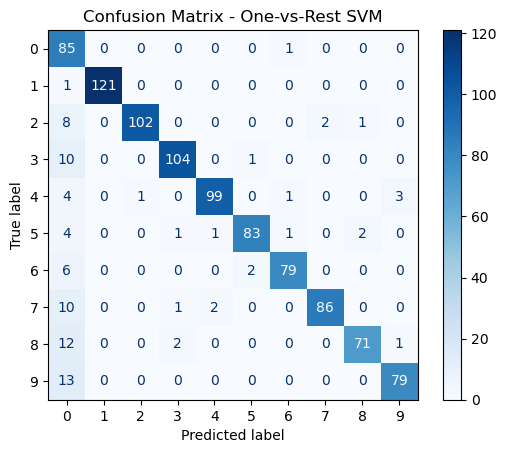

In [177]:
## Write and Run Your Own Code Here
## Please Add Additional Cells as Needed.
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# OneVsRest Confusion MAtrix
print("\nTraining One-vs-Rest SVM...")
ovr = OneVsRest(C=best_C)
ovr.fit(train_samples, train_samples_labels)

print("Evaluating One-vs-Rest SVM...")
y_pred_ovr = ovr.predict(test_samples)
accuracy_ovr = accuracy_score(test_samples_labels, y_pred_ovr)
print(f"One-vs-Rest SVM Accuracy: {accuracy_ovr:.4f}")

# Generate Confusion Matrix for One-vs-Rest SVM
conf_matrix_ovr = confusion_matrix(test_samples_labels, y_pred_ovr)

# Display Confusion Matrix
plt.figure(figsize=(8, 6))
disp_ovr = ConfusionMatrixDisplay(conf_matrix_ovr)
disp_ovr.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix - One-vs-Rest SVM")
plt.show()


Training One-vs-One SVM...
Evaluating One-vs-One SVM...
One-vs-One SVM Accuracy on Test Data: 0.9460


<Figure size 800x600 with 0 Axes>

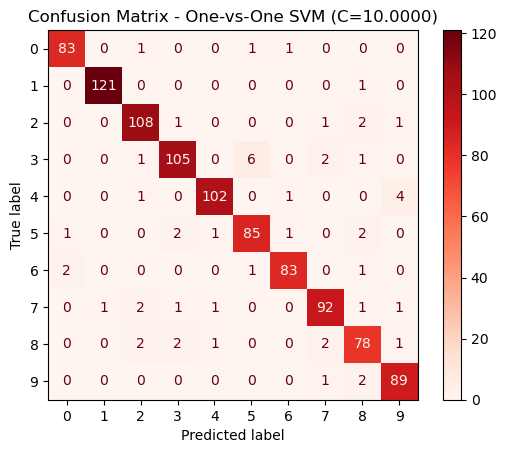

In [178]:
# train o v o using the best C value
print("\nTraining One-vs-One SVM...")
ovo_svm = OneVsOne(C=best_C)
ovo_svm.fit(train_samples, train_samples_labels)

# evaluate on test data
print("Evaluating One-vs-One SVM...")
y_pred_ovo = ovo_svm.predict(test_samples)
accuracy_ovo = accuracy_score(test_samples_labels, y_pred_ovo)
print(f"One-vs-One SVM Accuracy on Test Data: {accuracy_ovo:.4f}")

# generate confusion Matrix
conf_matrix_ovo = confusion_matrix(test_samples_labels, y_pred_ovo)

# diplay
plt.figure(figsize=(8, 6))
disp_ovo = ConfusionMatrixDisplay(conf_matrix_ovo)
disp_ovo.plot(cmap="Reds", values_format="d")
plt.title(f"Confusion Matrix - One-vs-One SVM (C={best_C:.4f})")
plt.show()

### What to Submit
Please submit the following:

1. Completed notebook: `assignment-4.ipynb`, where the output of each cell is clearly displayed.

2. A brief write-up that answers the 5 questions posed in this lab and justifies your model. Ensure that any figures you create are accessible and easy to understand.

In this lab, we implemented a Support Vector Machine (SVM) for binary and multiclass classification using nonlinear kernels. A polynomial kernel of degree 3 was used to capture nonlinear relationships, and the optimization problem was solved using cvxopt. The SVM was extended to multiclass classification using two strategies: One-vs-Rest (OvR) and One-vs-One (OvO). OvR achieved an accuracy of 91%, while OvO performed slightly better at 94%. Hyperparameter tuning for the regularization parameter C identified C = 1.0 as optimal for OvR strategies, and C= 10.0 for OvO, balancing margin size and classification errors.

Confusion matrices were generated to analyze model performance, revealing that most classes were correctly classified, with some confusion between visually similar digits (e.g., 4 and 9). These matrices provided valuable insights into areas for improvement. Overall, the SVM demonstrated strong performance on the MNIST dataset, achieving high accuracy and effectively handling multiclass classification.

Future work could explore other kernels (e.g., RBF), approximation methods for scalability, and ensemble techniques to further enhance performance. This lab highlighted the versatility and effectiveness of SVMs for complex classification tasks.